<a href="https://colab.research.google.com/github/lwyuki0524/DS_HW4_Text_Polarity_Classification/blob/main/%5BA4%5D_Text_Polarity_Classification_110423027_%E6%9D%8E%E5%AE%9B%E6%AF%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

李宛毓 110423027

## 載入套件和資料集

In [ ]:
!pip install nltk
!pip install -q transformers

     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
     |████████████████████████████████| 6.6 MB 40.1 MB/s 


In [ ]:
# 前處理
import pandas as pd
import re, string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# BERT
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Glove
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Word2Vec
from gensim.models import Word2Vec
import gensim.downloader

import numpy as np
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_df = pd.read_csv('train_2022.csv')
test_df = pd.read_csv('test_no_answer_2022.csv')
train_df

,row_id,TEXT,LABEL
0,0,director dirk shafer and co-writer greg hinton...,0
1,1,"a charming , quirky and leisurely paced scotti...",1
2,2,"the price was good , and came quickly though ...",1
3,3,i was looking forward to this game for a coupl...,0
4,4,arguably the year 's silliest and most incoher...,0
...,...,...,...
1995,1995,an imaginative comedy\/thriller .,1
1996,1996,a savvy exploration of paranoia and insecurity...,1
1997,1997,on the other hand for power grating you ve got...,1
1998,1998,"like dickens with his passages , mcgrath craft...",1


In [ ]:
test_df

,row_id,TEXT
0,0,good to know if you can t find these elsewhere .
1,1,love it ! the grill plates come out and pop i...
2,2,i m convinced this was a poorly executed refur...
3,3,i would never have complained about that if it...
4,4,"the photo shows the same whole , large candie..."
...,...,...
10995,10995,i didn t quite get it the first time .
10996,10996,i ve tried installing with and without the oem...
10997,10997,i was parked at a truck stop in the cincinnati...
10998,10998,i recently bought this case after seeing some ...


## 文字前處理

In [ ]:
# lowercase
train_df["TEXT"] = train_df["TEXT"].str.lower()
test_df["TEXT"] = test_df["TEXT"].str.lower()

##### decontracted + 去除標點符號跟數字
* train_sentence
* test_sentence



In [ ]:
def decontracted(sent):
  # 否定
  sent = re.sub( r"ca n't "," can not ",sent)
  sent = re.sub( r"can t "," can not ",sent)
  sent = re.sub( r"couldn t "," could not ",sent)
  sent = re.sub( r"wo n't "," will not ",sent)
  sent = re.sub( r"won t "," will not ",sent)
  sent = re.sub( r"would n't "," would not ",sent)
  sent = re.sub( r"wouldn t "," would not ",sent)
  sent = re.sub( r"n t "," not ",sent)
  sent = re.sub( r"n\'t "," not ",sent)

  # 肯定
  sent = re.sub( r"'ll "," will ",sent)
  sent = re.sub( r" ll "," will ",sent)
  sent = re.sub( r"\'d "," would ",sent)
  sent = re.sub( r" d "," would ",sent)
  sent = re.sub( r"\'ve "," have ",sent)
  sent = re.sub( r" ve "," have ",sent)
  sent = re.sub( r"\'s "," is ",sent)
  sent = re.sub( r" s "," is ",sent)
  sent = re.sub( r"\'m "," am ",sent)
  sent = re.sub( r" m "," am ",sent)
  sent = re.sub( r"\'re "," are ",sent)
  sent = re.sub( r" re "," are ",sent)
  return sent

# 移除數字 & 標點符號
def removed_s(sent):
  sent = re.sub( r'[0-9]+', '', sent )
  sent = sent.translate(str.maketrans( '', '' , string.punctuation))
  return sent

In [ ]:
# decontracted
# 去除標點符號跟數字

def decontr(df_text):
  sentence = []
  for row in df_text.TEXT:
    sent = decontracted( row ) # decontracted
    sent = removed_s( sent ) # 去除標點符號跟數字
    sentence.append( sent )
  sentence
  return sentence

train_sentence = decontr( train_df )
test_sentence = decontr( test_df )
train_sentence

['director dirk shafer and cowriter greg hinton ride the dubious divide where gay porn reaches for serious drama ',
 'a charming  quirky and leisurely paced scottish comedy  except with an outrageous central gimmick that could have been a reject from monty python  is meaning of life ',
 'the price was good   and came quickly though my prime membership ',
 'i was looking forward to this game for a couple of numextend',
 'arguably the year  is silliest and most incoherent movie ',
 'emerges as something rare  an issue movie that  is so honest and keenly observed that it does  not feel like one ',
 'anyway i recommend this one for its price and quality ',
 'it seems to be of very good quality in its build ',
 ' there are enough moments of heartbreaking honesty to keep one glued to the screen ',
 'they get into the corners as described and are flexible yet firm ',
 'it extends the writings of jean genet and john rechy  the films of fassbinder  perhaps even the nocturnal works of goya ',
 '

##### 切token
* train_tokened_sent
* test_tokened_sent

In [ ]:
# tokenization

def tokened(sent):
  tokened_sent = []
  for row in sent:
    tokened_sent.append( word_tokenize( row ) )
  return tokened_sent

test_tokened_sent = tokened(test_sentence)
train_tokened_sent = tokened(train_sentence)

print(train_tokened_sent)


[['director', 'dirk', 'shafer', 'and', 'cowriter', 'greg', 'hinton', 'ride', 'the', 'dubious', 'divide', 'where', 'gay', 'porn', 'reaches', 'for', 'serious', 'drama'], ['a', 'charming', 'quirky', 'and', 'leisurely', 'paced', 'scottish', 'comedy', 'except', 'with', 'an', 'outrageous', 'central', 'gimmick', 'that', 'could', 'have', 'been', 'a', 'reject', 'from', 'monty', 'python', 'is', 'meaning', 'of', 'life'], ['the', 'price', 'was', 'good', 'and', 'came', 'quickly', 'though', 'my', 'prime', 'membership'], ['i', 'was', 'looking', 'forward', 'to', 'this', 'game', 'for', 'a', 'couple', 'of', 'numextend'], ['arguably', 'the', 'year', 'is', 'silliest', 'and', 'most', 'incoherent', 'movie'], ['emerges', 'as', 'something', 'rare', 'an', 'issue', 'movie', 'that', 'is', 'so', 'honest', 'and', 'keenly', 'observed', 'that', 'it', 'does', 'not', 'feel', 'like', 'one'], ['anyway', 'i', 'recommend', 'this', 'one', 'for', 'its', 'price', 'and', 'quality'], ['it', 'seems', 'to', 'be', 'of', 'very', '

##### 詞型還原
* train_lemmas_sent
* test_lemmas_sent

In [ ]:
# lemmatization

# 取得詞性
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

#詞型還原
def lemmas(tagged_sent):
  lemmas_sent = []
  for row in tagged_sent:
    lemm_word_list = []
    for tag in row:
      wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
      lemm_word_list.append(lemmatizer.lemmatize(tag[0], pos=wordnet_pos))
    lemmas_sent.append(lemm_word_list)
  return lemmas_sent

# 標註詞性
train_tagged_sent = [pos_tag(tags) for tags in train_tokened_sent]
test_tagged_sent = [pos_tag(tags) for tags in test_tokened_sent]

#進行詞型還原
lemmatizer = WordNetLemmatizer()
train_lemmas_sent = lemmas(train_tagged_sent)
test_lemmas_sent = lemmas(test_tagged_sent)

print(train_lemmas_sent)

[['director', 'dirk', 'shafer', 'and', 'cowriter', 'greg', 'hinton', 'ride', 'the', 'dubious', 'divide', 'where', 'gay', 'porn', 'reach', 'for', 'serious', 'drama'], ['a', 'charming', 'quirky', 'and', 'leisurely', 'paced', 'scottish', 'comedy', 'except', 'with', 'an', 'outrageous', 'central', 'gimmick', 'that', 'could', 'have', 'be', 'a', 'reject', 'from', 'monty', 'python', 'be', 'mean', 'of', 'life'], ['the', 'price', 'be', 'good', 'and', 'come', 'quickly', 'though', 'my', 'prime', 'membership'], ['i', 'be', 'look', 'forward', 'to', 'this', 'game', 'for', 'a', 'couple', 'of', 'numextend'], ['arguably', 'the', 'year', 'be', 'silliest', 'and', 'most', 'incoherent', 'movie'], ['emerges', 'a', 'something', 'rare', 'an', 'issue', 'movie', 'that', 'be', 'so', 'honest', 'and', 'keenly', 'observe', 'that', 'it', 'do', 'not', 'feel', 'like', 'one'], ['anyway', 'i', 'recommend', 'this', 'one', 'for', 'it', 'price', 'and', 'quality'], ['it', 'seem', 'to', 'be', 'of', 'very', 'good', 'quality', 

##### 刪除停用詞
* train_stopw_sent
* test_stopw_sent

In [ ]:
# 刪除部分停用詞
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at","be", "because", 
             "been", "before", "being",  "between", "both", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "for", "from",  "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of", "on", "once", 
             "other", "ought", "our", "ours", "ourselves",  "own",  "she", "she'd", "she'll", "she's", 
             "so", "some", "such",  "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too",  
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

def remove_stopwords(lemmas_sent):
  removed_stopw = []
  for row in lemmas_sent:
    removed_stopw_list = []
    for tokened in row:
      if tokened not in  stopwords:
        removed_stopw_list.append(tokened)
    removed_stopw.append(removed_stopw_list)
  return removed_stopw

train_stopw_sent = remove_stopwords( train_lemmas_sent )
test_stopw_sent = remove_stopwords( test_lemmas_sent )
print(train_stopw_sent)

[['director', 'dirk', 'shafer', 'cowriter', 'greg', 'hinton', 'ride', 'dubious', 'divide', 'gay', 'porn', 'reach', 'serious', 'drama'], ['charming', 'quirky', 'leisurely', 'paced', 'scottish', 'comedy', 'except', 'outrageous', 'central', 'gimmick', 'reject', 'monty', 'python', 'mean', 'life'], ['price', 'good', 'come', 'quickly', 'though', 'prime', 'membership'], ['look', 'forward', 'game', 'couple', 'numextend'], ['arguably', 'year', 'silliest', 'incoherent', 'movie'], ['emerges', 'something', 'rare', 'issue', 'movie', 'honest', 'keenly', 'observe', 'not', 'feel', 'like', 'one'], ['anyway', 'recommend', 'one', 'price', 'quality'], ['seem', 'good', 'quality', 'build'], ['enough', 'moment', 'heartbreaking', 'honesty', 'keep', 'one', 'glue', 'screen'], ['get', 'corner', 'described', 'flexible', 'yet', 'firm'], ['extend', 'writing', 'jean', 'genet', 'john', 'rechy', 'film', 'fassbinder', 'perhaps', 'even', 'nocturnal', 'work', 'goya'], ['liman', 'swinger', 'go', 'make', 'bigbudget', 'acti

## Word embedding

### BERT
* 訓練集：data_train
* 驗證集：data_valid

In [ ]:
# 載入 BERT 預訓練的 Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 使用 BERT 對句子進行編碼、補零

max_length = 130 # 句子編碼後的長度

# 儲存 bert 要輸入的三個格式的串列
input_ids_list = [] 
token_type_ids_list = [] 
attention_mask_list = [] 
label_list = []

dict_train = {}
def train_dict_label(input_ids, attention_masks, token_type_ids, label):
  return { "input_ids": input_ids, "token_type_ids": token_type_ids, "attention_mask": attention_masks,}, label

for index, row in enumerate(train_tokened_sent): # train_sentence:不切Token ； train_tokened_sent:切了token ； train_lemmas_sent ：詞型還原 ； train_stopw_sent ：刪除停用詞
  # 將要輸入的句子編碼、補零
  encoded = bert_tokenizer(row, padding='max_length', truncation=True, max_length = max_length, is_split_into_words=True) # , is_split_into_words=True # 切了token要加上這個

  # bert 要輸入的三個格式: input_ids、token_type_ids、attention_mask
  input_ids_list.append( encoded['input_ids'] ) 
  token_type_ids_list.append( encoded['token_type_ids'] ) 
  attention_mask_list.append( encoded['attention_mask'] )
  # label
  label_list.append( [train_df["LABEL"][index]] )

# 創建{input_ids、token_type_ids、attention_mask}對應 label 的資料集
train_df_encoded = tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(train_dict_label)
print( train_df_encoded )

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(130,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(130,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(130,), dtype=tf.int32, name=None)}, TensorSpec(shape=(1,), dtype=tf.int32, name=None))>


In [ ]:
# 切分訓練集 & 驗證集

# 打亂、分批
batch_size = 8
batch_train = train_df_encoded.shuffle(10000).batch(batch_size)

# 分割訓練集和驗證集
train_size = int(len(list(batch_train))*0.8)
data_train = batch_train.take(train_size)
data_valid = batch_train.skip(train_size)
data_train

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, 130), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 130), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 130), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

### Glove

In [ ]:
# 下載 預訓練的 Glove 詞向量
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!rm glove.6B.zip

--2022-05-17 15:01:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-17 15:01:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-17 15:01:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# 使用 預訓練的 Glove 詞向量
embeddings_index = {}
f = open('glove.6B.50d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]  # 第一個是詞彙，把他取出來
    coefs = np.asarray(values[1:], dtype='float32') # 第一個之後是這個字的向量
    embeddings_index[word] = coefs  # 每個字對應到它的向量，存在embeddings_index裡
f.close()

print('Total %s word vectors in Glove 6B 50d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 50d.


In [ ]:
# 將句子編碼
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentence) # train_sentence :不切Token ； train_tokened_sent :切了token ； train_lemmas_sent ：詞型還原 ； train_stopw_sent ：刪除停用詞
train_sequences = tokenizer.texts_to_sequences(train_sentence)
test_sentences = tokenizer.texts_to_sequences(test_sentence)
word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 6121


In [ ]:
# 建立嵌入矩陣 ( 要丟給LSTM嵌入層的權重 )
EMBEDDING_DIM = 50
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Word2Vec

In [ ]:
# 建立 Word2Vec 模型
# 使用google news的預訓練詞向量
w2v_model = gensim.downloader.load('word2vec-google-news-300')
w2v_model

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
vocab_list = list(w2v_model.wv.vocab.keys())
print(w2v_model['in'].shape)
print('length:', len(vocab_list))
print('vocab_list：',vocab_list[:10])

(300,)
length: 3000000
vocab_list： ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
# 將句子編碼
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentence) # train_sentence :不切Token ； train_tokened_sent :切了token ； train_lemmas_sent ：詞型還原 ； train_stopw_sent ：刪除停用詞
train_sequences = tokenizer.texts_to_sequences(train_sentence)
test_sentences = tokenizer.texts_to_sequences(test_sentence)
word_index = tokenizer.word_index
print(word_index)

print('Number of Unique Tokens',len(word_index))

{'the': 1, 'a': 2, 'is': 3, 'and': 4, 'it': 5, 'of': 6, 'to': 7, 'i': 8, 'this': 9, 'not': 10, 'that': 11, 'in': 12, 'for': 13, 'with': 14, 'as': 15, 'have': 16, 'but': 17, 'you': 18, 'on': 19, 'its': 20, 'be': 21, 'are': 22, 'an': 23, 'film': 24, 'my': 25, 'all': 26, 'like': 27, 'one': 28, 'movie': 29, 'so': 30, 'will': 31, 'at': 32, 'more': 33, 'by': 34, 'from': 35, 'about': 36, 'was': 37, 'just': 38, 'than': 39, 'very': 40, 'has': 41, 'would': 42, 'what': 43, 'good': 44, 'does': 45, 'they': 46, 'do': 47, 'can': 48, 'if': 49, 'or': 50, 'his': 51, 'too': 52, 'no': 53, 'out': 54, 'there': 55, 'even': 56, 'much': 57, 'time': 58, 'most': 59, 'them': 60, 'little': 61, 'numnum': 62, 'up': 63, 'great': 64, 'these': 65, 'when': 66, 'been': 67, 'had': 68, 'well': 69, 'we': 70, 'into': 71, 'use': 72, 'get': 73, 'your': 74, 'some': 75, 'who': 76, 'way': 77, 'story': 78, 'only': 79, 'first': 80, 'better': 81, 'comedy': 82, 'over': 83, 'product': 84, 'did': 85, 'rrb': 86, 'make': 87, 'really': 88

In [ ]:
# 建立嵌入矩陣 ( 要丟給LSTM嵌入層的權重 )
EMBEDDING_DIM = 300
embedding_matrix = np.random.random(( len(word_index)+1, EMBEDDING_DIM ))
for word, i in word_index.items():
    if w2v_model.wv.__contains__(word):
        embedding_matrix[i] = w2v_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Embedding Matrix Shape: (6122, 300)


### 切割資料集 & 驗證集 (W2V & Glove使用)

In [ ]:
# 切分資料集 & 驗證集
input_length = 200

def split_train_valid():
  # 將編碼後的句子補零
  train_data = pad_sequences(train_sequences, maxlen=input_length)
  train_label = np.array(train_df["LABEL"])
  test_data = pad_sequences(test_sentences, maxlen=input_length)
  
  # 打亂順序
  index = np.arange(train_data.shape[0])
  np.random.shuffle(index)
  data = train_data[index]
  labels = train_label[index]
  
  # 切分成 8:2
  data_size = int(data.shape[0]*0.8)
  x_train = data[:data_size]
  y_train = labels[:data_size]
  x_val = data[data_size:]
  y_val = labels[data_size:]

  print( x_train.shape, y_train.shape  )
  print( x_val.shape, y_val.shape  )
  print( test_data.shape  )
  return x_train, y_train, x_val, y_val, test_data

x_train, y_train, x_val, y_val, test_data = split_train_valid()


(1600, 200) (1600,)
(400, 200) (400,)
(11000, 200)


## 建立模型

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding, Dropout
from keras.layers import TimeDistributed

from keras.layers import SimpleRNN, Conv1D, ZeroPadding1D, GRU
from keras.layers.normalization.batch_normalization import BatchNormalization

from keras.layers.pooling import MaxPool1D
from tensorflow.keras.optimizers import Adam

from keras import backend as K 

from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt

In [ ]:
# 重跑模型的話再執行這個
K.clear_session()
del model

### BERT

In [ ]:
# 參數設定：learning_rate 、 epoch
learning_rate = 3e-5
epochs = 4

# 載入 Bert 預訓練模型
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 訓練
bert_history = model.fit(data_train, epochs=epochs, validation_data=data_valid)

Epoch 1/4
200/200 [==============================] - 134s 565ms/step - loss: 0.5763 - accuracy: 0.6819 - val_loss: 0.2973 - val_accuracy: 0.8900
Epoch 2/4
200/200 [==============================] - 109s 545ms/step - loss: 0.3652 - accuracy: 0.8500 - val_loss: 0.1585 - val_accuracy: 0.9500
Epoch 3/4
200/200 [==============================] - 109s 546ms/step - loss: 0.1771 - accuracy: 0.9337 - val_loss: 0.0306 - val_accuracy: 0.9925
Epoch 4/4
200/200 [==============================] - 109s 545ms/step - loss: 0.1010 - accuracy: 0.9675 - val_loss: 0.0248 - val_accuracy: 0.9925


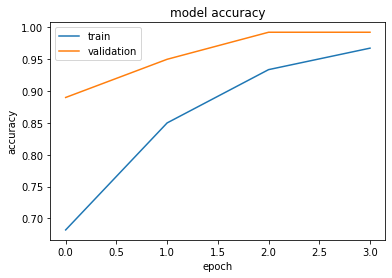

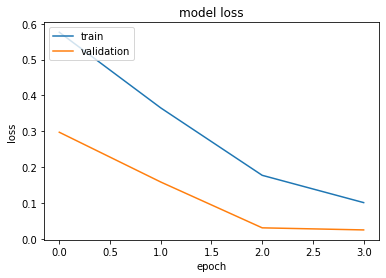

In [ ]:
plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### BiLSTM

In [ ]:
def BiLSTM_model():
    embedding_layer = Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False)
    
    model = Sequential()
    model.add( embedding_layer )
    model.add(Bidirectional(LSTM(64, dropout=0.5, return_sequences=True)))
    
    model.add(Dense(64))
    model.add(Dropout(0.5))

    # model.add(BatchNormalization() )
    model.add(GlobalMaxPool1D())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
lstm_model = BiLSTM_model()
lstm_model.summary()
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001,epsilon=1e-07), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          1559100   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 200, 64)           8256      
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
# 訓練
lstm_history = lstm_model.fit( x_train, y_train, batch_size=15, epochs=15, verbose=1, validation_data = (x_val,y_val))

Epoch 1/15
107/107 [==============================] - 15s 101ms/step - loss: 0.7170 - accuracy: 0.5050 - val_loss: 0.6810 - val_accuracy: 0.5400
Epoch 2/15
107/107 [==============================] - 10s 91ms/step - loss: 0.6658 - accuracy: 0.5825 - val_loss: 0.6394 - val_accuracy: 0.6750
Epoch 3/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5909 - accuracy: 0.6900 - val_loss: 0.5984 - val_accuracy: 0.7050
Epoch 4/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5594 - accuracy: 0.7125 - val_loss: 0.5996 - val_accuracy: 0.6875
Epoch 5/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5355 - accuracy: 0.7212 - val_loss: 0.6015 - val_accuracy: 0.6425
Epoch 6/15
107/107 [==============================] - 10s 92ms/step - loss: 0.5135 - accuracy: 0.7444 - val_loss: 0.5990 - val_accuracy: 0.6750
Epoch 7/15
107/107 [==============================] - 10s 90ms/step - loss: 0.5029 - accuracy: 0.7506 - val_loss: 0.5919 - val_accuracy

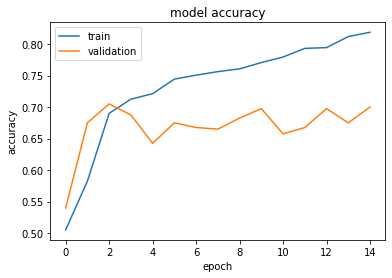

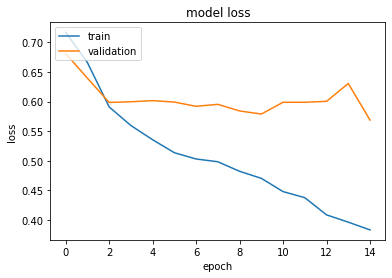

In [ ]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### BiLSTM + CNN

In [ ]:
def LSTM_CNN_model():
    embedding_layer = Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False)
    
    model = Sequential()
    model.add( embedding_layer )
    model.add(Bidirectional(LSTM(64, dropout=0.5, return_sequences=True)))
    model.add(Conv1D(32, 4, activation='relu')),
    model.add( MaxPool1D() )
    model.add(Dropout(0.5))
    model.add(GlobalMaxPool1D()),
    # model.add(BatchNormalization() )
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
lstm_cnn_model = LSTM_CNN_model()
lstm_cnn_model.summary()
lstm_cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=1e-07), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          1559100   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         186880    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 197, 32)           16416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 32)            0         
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0

In [ ]:
lstm_cnn_history = lstm_cnn_model.fit( x_train, y_train, batch_size=15, epochs=15, verbose=1, validation_data = (x_val,y_val) )

Epoch 1/15
107/107 [==============================] - 15s 101ms/step - loss: 0.7326 - accuracy: 0.5119 - val_loss: 0.6828 - val_accuracy: 0.5525
Epoch 2/15
107/107 [==============================] - 10s 92ms/step - loss: 0.6764 - accuracy: 0.5525 - val_loss: 0.6448 - val_accuracy: 0.6625
Epoch 3/15
107/107 [==============================] - 10s 91ms/step - loss: 0.6372 - accuracy: 0.6325 - val_loss: 0.6128 - val_accuracy: 0.6900
Epoch 4/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5831 - accuracy: 0.6850 - val_loss: 0.6012 - val_accuracy: 0.7075
Epoch 5/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5392 - accuracy: 0.7269 - val_loss: 0.5901 - val_accuracy: 0.6550
Epoch 6/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5332 - accuracy: 0.7337 - val_loss: 0.5854 - val_accuracy: 0.6925
Epoch 7/15
107/107 [==============================] - 10s 91ms/step - loss: 0.5194 - accuracy: 0.7456 - val_loss: 0.6014 - val_accuracy

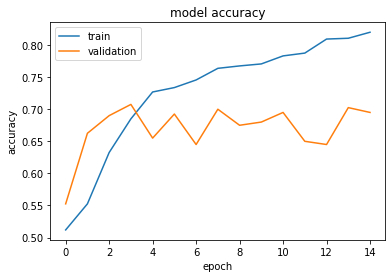

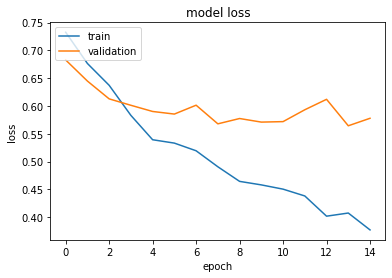

In [ ]:
plt.plot(lstm_cnn_history.history['accuracy'])
plt.plot(lstm_cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(lstm_cnn_history.history['loss'])
plt.plot(lstm_cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 預測測試集

#### BERT

In [ ]:
test_predict_input = []
result = []
for row in test_tokened_sent: # test_tokened_sent ：切了token 、 test_sentence ：沒切token、 test_lemmas_sent :詞型還原、 test_stopw_sent ：刪除停用詞
  input = bert_tokenizer.encode(row, truncation=True, padding=True, return_tensors="tf")
  test_output = model.predict(input)[0]
  test_prediction = tf.nn.softmax(test_output, axis=1)
  label = tf.argmax(test_prediction, axis=1)
  label = label.numpy()
  result.append( label[0] )
print(result)

[1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 

#### Glove & W2V

In [ ]:
# 預測測試集
y_pred = lstm_model.predict(test_data)
y_pred = np.where(y_pred>=0.5, 1, 0)
print(y_pred)
result = y_pred

[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


#### 輸出結果

In [ ]:
# 轉CSV檔
predicted_df = pd.DataFrame(result, columns=['LABEL'])
predicted_df.index.name="row_id"
predicted_df.to_csv("BERT_token_b8e4_l3.csv")
predicted_df

,LABEL
row_id,
0,1
1,1
2,0
3,0
4,0
...,...
10995,0
10996,1
10997,0
